In [1]:
!pip install scikit-image

from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray  # New import
import numpy as np
from PIL import Image

def calculate_glcm(image, dx=1, dy=0):
    """Calculate GLCM for an image (handles both grayscale and RGB)"""
    image_array = np.array(image)
    if len(image_array.shape) == 3:
        image_array = rgb2gray(image_array)
    channel = img_as_ubyte(image_array)
    return graycomatrix(channel, distances=[dx], angles=[dy], symmetric=True, normed=True)

def extract_glcm_features(glcm):
    """Extract features from GLCM"""
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

def extract_rgb_features(image):
    """Extract basic RGB statistics"""
    arr = np.array(image)
    features = []
    for i in range(3):  # R, G, B channels
        channel = arr[:,:,i]
        features.extend([np.mean(channel), np.std(channel), np.median(channel)])
    return features

def extract_glcm_rgb_features(image):
    """Combine GLCM and RGB features"""
    glcm = calculate_glcm(image)
    glcm_feats = extract_glcm_features(glcm)
    rgb_feats = extract_rgb_features(image)
    return glcm_feats + rgb_feats

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

class_paths = {
    0: ("tiger", "/content/drive/MyDrive/Dataset/tiger"),
    1: ("lion", "/content/drive/MyDrive/Dataset/lion"),
    2: ("cheetah", "/content/drive/MyDrive/Dataset/cheetah"),
    3: ("leopard", "/content/drive/MyDrive/Dataset/leopard")
}


class_names = [v[0] for v in sorted(class_paths.values())]
dataset_paths = [v[1] for v in sorted(class_paths.values())]


def load_dataset(paths, img_size=(256, 256)):
    all_features = []
    all_labels = []

    for label, folder_path in enumerate(paths):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                try:
                    image_path = os.path.join(folder_path, filename)
                    image = Image.open(image_path).convert("RGB").resize(img_size)
                    features = extract_glcm_rgb_features(image)
                    all_features.append(features)
                    all_labels.append(label)
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue

    return np.array(all_features), np.array(all_labels)

X, y = load_dataset(dataset_paths)

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)  # Changed from 'sparse' to 'sparse_output'
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (552, 14), Test set: (139, 14)


In [4]:
import numpy as np
import json

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        prev_size = input_size
        for size in hidden_sizes:
            self.weights.append(np.random.randn(prev_size, size) * 0.1)
            self.biases.append(np.zeros(size))
            prev_size = size

        # Output layer
        self.weights.append(np.random.randn(prev_size, output_size) * 0.1)
        self.biases.append(np.zeros(output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x):
        self.activations = [x]
        self.z_values = []

        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            activation = self.softmax(z) if i == len(self.weights)-1 else self.sigmoid(z)
            self.activations.append(activation)

        return self.activations[-1]

    def backward(self, x, y, learning_rate):
        output = self.forward(x)
        error = output - y
        deltas = [error]

        # Backpropagate
        for i in range(len(self.weights)-1, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T) * self.sigmoid_derivative(self.activations[i])
            deltas.append(delta)

        deltas.reverse()

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * np.dot(self.activations[i].T, deltas[i])
            self.biases[i] -= learning_rate * np.sum(deltas[i], axis=0)

    def train(self, X, y, epochs, learning_rate, validation_data=None):
        for epoch in range(epochs):
            self.backward(X, y, learning_rate)

            if epoch % 100 == 0:
                output = self.forward(X)
                loss = -np.mean(y * np.log(output + 1e-9))

                if validation_data:
                    X_val, y_val = validation_data
                    val_pred = self.predict_class(X_val)
                    val_true = np.argmax(y_val, axis=1)
                    val_acc = np.mean(val_pred == val_true)
                    print(f"Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.2%}")
                else:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict_class(self, X):
        proba = self.forward(X)
        return np.argmax(proba, axis=1)

    def predict_proba(self, X):
        return self.forward(X)

    def save_model(self, filename):
        model_data = {
            'weights': [w.tolist() for w in self.weights],
            'biases': [b.tolist() for b in self.biases],
            'input_size': self.weights[0].shape[0],
            'hidden_sizes': [w.shape[1] for w in self.weights[:-1]],
            'output_size': self.weights[-1].shape[1]
        }
        with open(filename, 'w') as f:
            json.dump(model_data, f)

    @staticmethod
    def load_model(filename):
        with open(filename, 'r') as f:
            model_data = json.load(f)

        model = NeuralNetwork(
            model_data['input_size'],
            model_data['hidden_sizes'],
            model_data['output_size']
        )

        model.weights = [np.array(w) for w in model_data['weights']]
        model.biases = [np.array(b) for b in model_data['biases']]

        return model

In [5]:
from google.colab import files
from IPython.display import display

def extract_features_from_image(image_path, img_size=(256, 256)):
    """Extract features from a single image"""
    image = Image.open(image_path).convert("RGB").resize(img_size)
    return extract_glcm_rgb_features(image)

def predict_image(image_path, model, feature_mean, feature_std, class_names):
    """Make prediction on a single image"""
    features = extract_features_from_image(image_path)
    features_normalized = (features - feature_mean) / (feature_std + 1e-6)
    proba = model.predict_proba(features_normalized.reshape(1, -1))[0]
    pred_class = np.argmax(proba)
    return pred_class, proba, class_names[pred_class]

def interactive_prediction(model, feature_mean, feature_std, class_names):
    """Upload and predict images interactively"""
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\nPredicting: {filename}")
        img = Image.open(filename)
        display(img.resize((200, 200)))

        pred_class, proba, class_name = predict_image(
            filename, model, feature_mean, feature_std, class_names)

        print(f"Predicted class: {class_name}")
        print("Class probabilities:")
        for i, name in enumerate(class_names):
            print(f"  {name}: {proba[i]:.2%}")

In [6]:
# Initialize and train network
input_size = X_train.shape[1]
output_size = y_train.shape[1]
ann = NeuralNetwork(input_size, [64, 32], output_size)

ann.train(
    X_train, y_train,
    epochs=30000,
    learning_rate=0.0001,
    validation_data=(X_test, y_test)
)

# Save model and scaler
ann.save_model('ann_glcm_model.json')
np.savez('scaler_params.npz', mean=scaler.mean_, scale=scaler.scale_)

# Evaluate
test_preds = ann.predict_class(X_test)
test_true = np.argmax(y_test, axis=1)
accuracy = np.mean(test_preds == test_true)

Epoch 0, Loss: 0.3581, Val Acc: 18.71%
Epoch 100, Loss: 0.3460, Val Acc: 26.62%
Epoch 200, Loss: 0.3451, Val Acc: 26.62%
Epoch 300, Loss: 0.3440, Val Acc: 26.62%
Epoch 400, Loss: 0.3427, Val Acc: 28.06%
Epoch 500, Loss: 0.3409, Val Acc: 36.69%
Epoch 600, Loss: 0.3384, Val Acc: 41.01%
Epoch 700, Loss: 0.3348, Val Acc: 42.45%
Epoch 800, Loss: 0.3299, Val Acc: 43.88%
Epoch 900, Loss: 0.3233, Val Acc: 47.48%
Epoch 1000, Loss: 0.3153, Val Acc: 49.64%
Epoch 1100, Loss: 0.3068, Val Acc: 48.92%
Epoch 1200, Loss: 0.2984, Val Acc: 46.76%
Epoch 1300, Loss: 0.2907, Val Acc: 47.48%
Epoch 1400, Loss: 0.2839, Val Acc: 46.76%
Epoch 1500, Loss: 0.2781, Val Acc: 45.32%
Epoch 1600, Loss: 0.2733, Val Acc: 46.04%
Epoch 1700, Loss: 0.2694, Val Acc: 46.76%
Epoch 1800, Loss: 0.2662, Val Acc: 48.92%
Epoch 1900, Loss: 0.2636, Val Acc: 50.36%
Epoch 2000, Loss: 0.2615, Val Acc: 49.64%
Epoch 2100, Loss: 0.2598, Val Acc: 51.80%
Epoch 2200, Loss: 0.2583, Val Acc: 51.80%
Epoch 2300, Loss: 0.2570, Val Acc: 51.80%
Epoc


Test Accuracy: 55.40%

Classification Report:
              precision    recall  f1-score   support

     cheetah       0.67      0.49      0.56        41
     leopard       0.45      0.40      0.42        35
        lion       0.51      0.81      0.63        26
       tiger       0.59      0.59      0.59        37

    accuracy                           0.55       139
   macro avg       0.56      0.57      0.55       139
weighted avg       0.56      0.55      0.55       139


Starting interactive prediction...


Saving Cheetah.jpg to Cheetah.jpg

Predicting: Cheetah.jpg


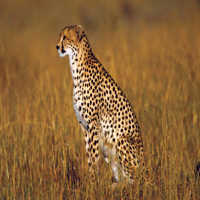

Predicted class: cheetah
Class probabilities:
  cheetah: 92.87%
  leopard: 5.85%
  lion: 0.01%
  tiger: 1.27%


In [7]:
def main():
    from sklearn.metrics import classification_report
    print("\nTest Accuracy: {:.2%}".format(accuracy))
    print("\nClassification Report:")
    print(classification_report(test_true, test_preds, target_names=class_names))

    print("\nStarting interactive prediction...")
    from google.colab import files
    interactive_prediction(ann, scaler.mean_, scaler.scale_, class_names)

if __name__ == "__main__":
    main()